In [1]:
import os
import cv2
import numpy as np
import glob
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


# Reading the Data

In [2]:
path_images = '/Users/arasdirekoglu/Documents/Daten/rs19_val/jpgs/rs19_val/' 
test = sorted(os.listdir(path_images))
breaks = 0 
for i in test:
    breaks += 1 
    if i.endswith('.jpg'):
        print(i)
    if breaks == 12:
        break 

rs00000.jpg
rs00001.jpg
rs00002.jpg
rs00003.jpg
rs00004.jpg
rs00005.jpg
rs00006.jpg
rs00007.jpg
rs00008.jpg
rs00009.jpg
rs00010.jpg


In [3]:
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Daten/rs19_val/uint8/rs19_val/'
test_masks = sorted(os.listdir(path_masks))
breaks = 0 
for i in test_masks:
    breaks += 1 
    if i.endswith('.png'):
        print(i)
    if breaks == 11:
        break 

rs00000.png
rs00001.png
rs00002.png
rs00003.png
rs00004.png
rs00005.png
rs00006.png
rs00007.png
rs00008.png
rs00009.png
rs00010.png


In [4]:
## Images
# Setting up the directory for the files 
path_images = '/Users/arasdirekoglu/Documents/Daten/rs19_val/jpgs/rs19_val/' 

# Setting up a scaler 
scaler = MinMaxScaler()

# Setting up a breaker for test run 
breaker = 0

# Patch Size
patch_size = 256

# Setting up empty lists for image dataset 
image_dataset = []


# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop for Images  
for filename in sorted(os.listdir(path_images)):
    breaker += 1
    if filename.endswith('.jpg'):
        image = cv2.imread(path_images+filename)
        size_x = (image.shape[1]/patch_size)*patch_size
        size_y = (image.shape[0]/patch_size)*patch_size
        image = Image.fromarray(image)
        image = image.crop((0, 0, size_x, size_y))
        image = np.array(image)
        
        # Patchify
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                single_patch_img = single_patch_img[0]
                image_dataset.append(single_patch_img)
                
    if breaker==101:
        break

image_dataset = np.array(image_dataset)
print('image: ', image_dataset.shape)

image:  (2800, 256, 256, 3)


In [5]:
## Masks 
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Daten/rs19_val/uint8/rs19_val/'

# Setting up a breaker for test run 
breaker = 0

# Patch Size
patch_size = 256

# Setting up empty lists for image dataset 
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop for Masks  
for filename in sorted(os.listdir(path_masks)):
    breaker += 1
    if filename.endswith('.png'):
        mask = cv2.imread(path_masks+filename)
        size_x = (mask.shape[1]/patch_size)*patch_size
        size_y = (mask.shape[0]/patch_size)*patch_size
        mask = Image.fromarray(mask)
        mask = mask.crop((0, 0, size_x, size_y))
        mask = np.array(mask)
        for layer in range(len(mask[0,0,:])):
            # mask[:int(size_y/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1

        # Patchify
        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = scaler.fit_transform(single_patch_mask.reshape(-1, single_patch_mask.shape[-1])).reshape(single_patch_mask.shape)
                single_patch_mask = single_patch_mask[0]
                mask_dataset.append(single_patch_mask)

    if breaker==100:
        break

mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

mask:  (2800, 256, 256, 1)
unique labels in mask [0. 1.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


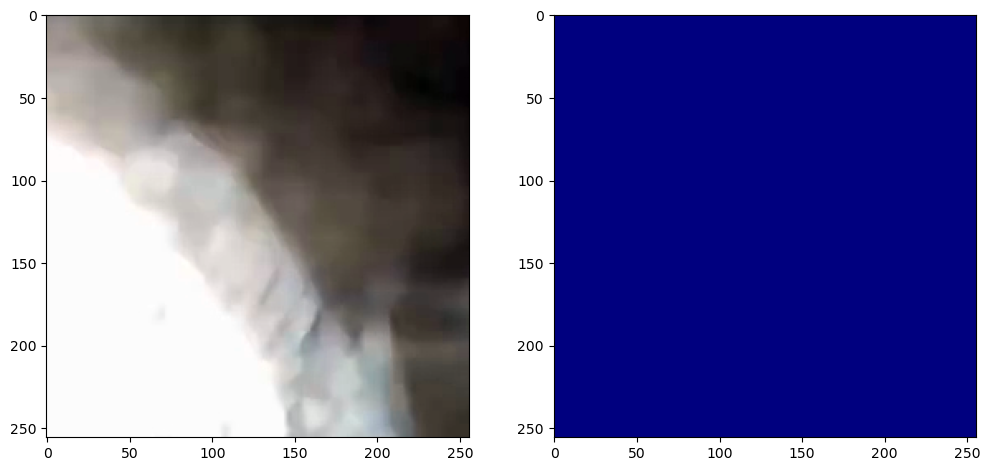

In [6]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(mask_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number],cmap='jet')
plt.show()

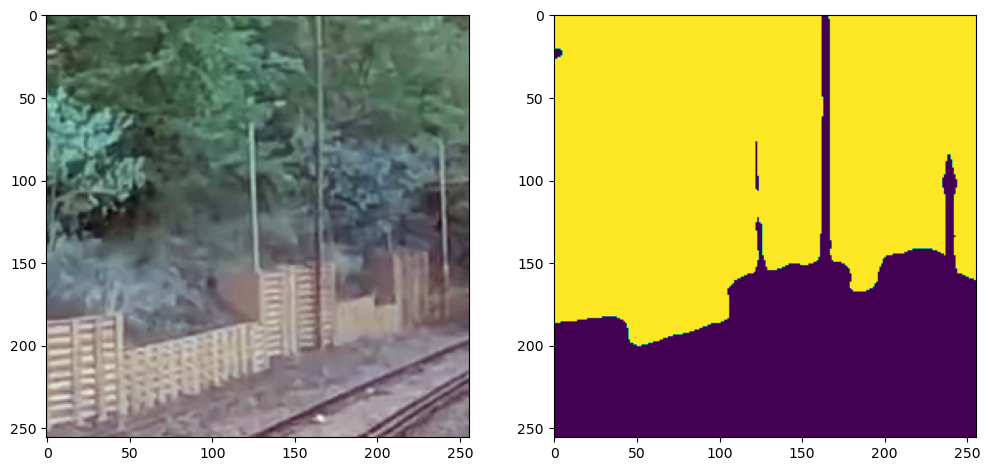

In [7]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(mask_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, -1)))
plt.show()

# Split of Data

In [8]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [9]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'densenet121'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [223]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

85521592/85521592 [==============================] - 9s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_36 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                       

In [224]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=10,
                        epochs=2,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/2
224/224 [==============================] - 962s 4s/step - loss: 0.3708 - iou_score: 0.3772 - mse: 0.1196 - val_loss: 0.7082 - val_iou_score: 9.1350e-11 - val_mse: 0.1928
Epoch 2/2
224/224 [==============================] - 961s 4s/step - loss: 0.3015 - iou_score: 0.4486 - mse: 0.0961 - val_loss: 0.6055 - val_iou_score: 9.1350e-11 - val_mse: 0.1843


1/1 [==============================] - 1s 885ms/step


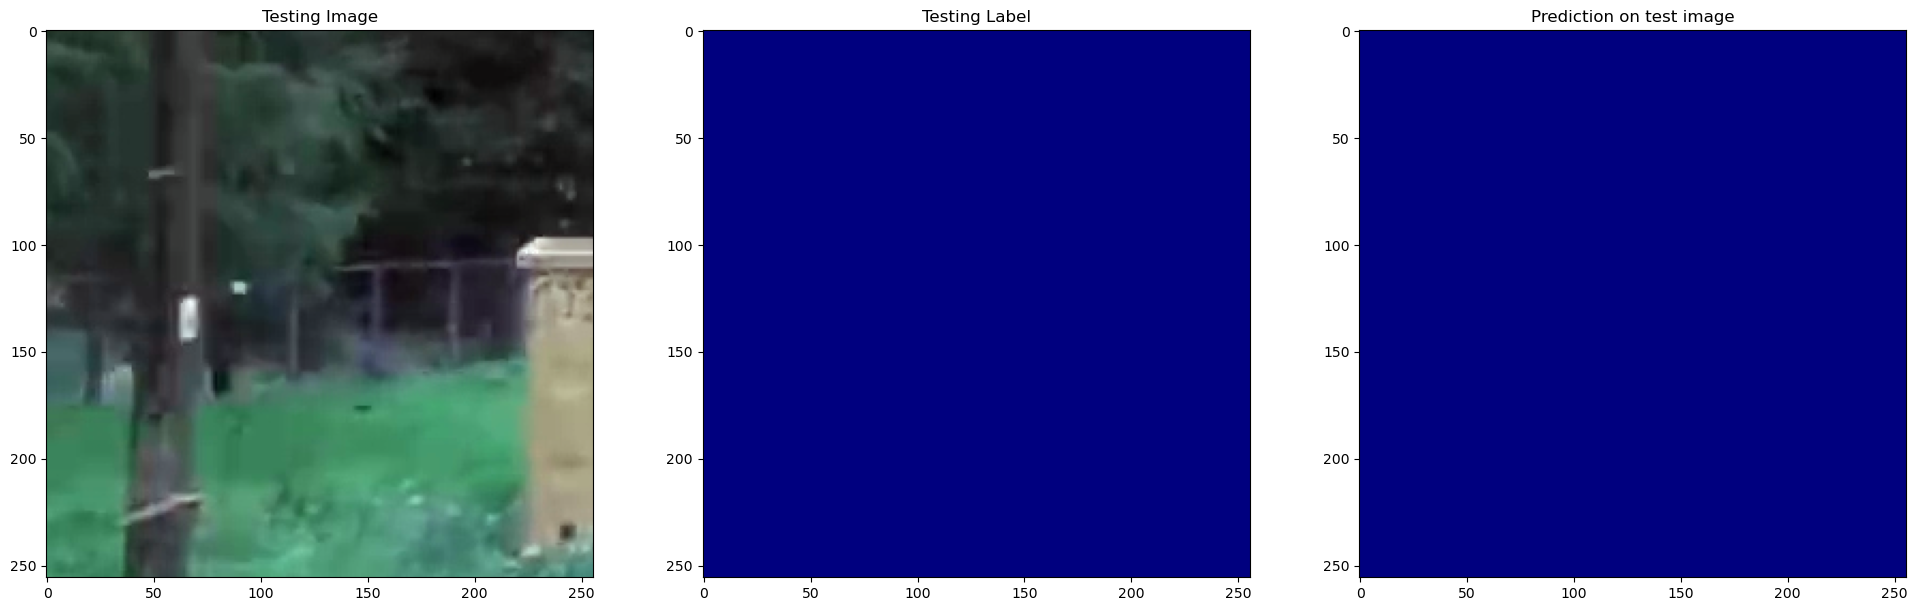

In [225]:
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
#test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
#my_threshold = 0.99
#predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()